<a href="https://colab.research.google.com/github/SydanJainen/Cell-image-segmentation/blob/main/image_Segmantation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CELL IMAGE SEGMENTATION

## HYPERPARAMETER


In [1]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNEL = 3

BATCH_SIZE = 8
EPOCHS = 100
PADDING = 10
STRIDE = 2
PATIENCE = 5

VAL_SPLIT = 0.30
SEED = 42

LEARNING_RATE = 1e-4
EPS = 1e-7

width_out = 256
height_out = 256

STEP_AUGMENTATION = 15

NAME = 'unet'

LossName = 'DiceLoss'

## CHECK IF COLAB OR OFFLINE

In [2]:
if 'google.colab' in str(get_ipython()):
  isColab = True
else:
  isColab = False

## CHECK IF GPU IS AVAILABLE

In [3]:
import torch

num_gpu = torch.cuda.device_count()
print(f'{num_gpu} GPU available')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

1 GPU available


## REQUIREMENT

In [4]:
if isColab:
  import os
  from google.colab import files, drive
  if (not 'kaggle.json' in os.listdir()):
    print("Upload kaggle.json")
    files.upload()
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
  drive.mount('/content/drive')
  DB_PATH = '/content/drive/MyDrive/scuola/deeplife/'
else:
  print("Check if folder is correct")
  DB_PATH = 'database/'

Check if folder is correct


## IMPORTS

In [5]:
if isColab:
    !pip install opencv-python
    !pip install tqdm

In [6]:
import os
import sys
import glob
import tqdm
import json
import gc
import datetime
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import cv2
from cv2 import imwrite
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as F
from sklearn.model_selection import train_test_split
import albumentations as A

In [7]:
# aplly SEED to all random functions
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

dateTime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

#create a fodler with the hyperparameters name to save the results
if not os.path.exists(f'results'):
    os.makedirs(f'results')
if not os.path.exists(f'results{NAME}/{NAME}_{EPOCHS}epochs_{BATCH_SIZE}batch_{PATIENCE}patience_{STEP_AUGMENTATION}augm'):
    os.makedirs(f'results{NAME}/{NAME}_{EPOCHS}epochs_{BATCH_SIZE}batch_{PATIENCE}patience_{STEP_AUGMENTATION}augm')
RESULTS_PATH = f'results{NAME}/{NAME}_{EPOCHS}epochs_{BATCH_SIZE}batch_{PATIENCE}patience_{STEP_AUGMENTATION}augm/'

In [8]:
if os.path.exists(DB_PATH):
    print("Database folder found")
else:
    print(" Generate the database")
    os.makedirs(DB_PATH)
    os.chdir(DB_PATH)
    if(isColab):
        !pip install kaggle
        !kaggle competitions download -c data-science-bowl-2018
        !unzip -q data-science-bowl-2018.zip -d ./
        !unzip -q cellular-segmentation/stage1_train.zip -d unpreocessed/
        if os.path.exists('./cellular-segmentation') and os.path.exists('./data-science-bowl-2018.zip'):
            !rm data-science-bowl-2018.zip
    else:
        print("Download the database and place it in the folder")
    os.chdir('..')

Database folder found


In [9]:
IMAGE_PATH = os.path.join(DB_PATH, "train")
LABEL_PATH = os.path.join(DB_PATH, "label")

if STEP_AUGMENTATION > 0:
    AUG_IMAGE_PATH = os.path.join(DB_PATH, "augmented/train")
    AUG_LABEL_PATH = os.path.join(DB_PATH, "augmented/label")

# Ensure both directories have the same number of files
number_images = len(os.listdir(IMAGE_PATH))
number_labels = len(os.listdir(LABEL_PATH))

if STEP_AUGMENTATION > 0:
    number_augmented_images = len(os.listdir(AUG_IMAGE_PATH))
    number_augmented_labels = len(os.listdir(AUG_LABEL_PATH))

assert number_images == number_labels

if STEP_AUGMENTATION > 0:
    assert number_augmented_images == number_augmented_labels

# LOAD PIL IMAGES AND LABELS
image_files = sorted(os.listdir(IMAGE_PATH))
label_files = sorted(os.listdir(LABEL_PATH))

if STEP_AUGMENTATION > 0:
    aug_image_files = sorted(os.listdir(AUG_IMAGE_PATH))
    aug_label_files = sorted(os.listdir(AUG_LABEL_PATH))

# Split into train and temp sets
train_images, val_images, train_labels, val_labels = train_test_split(image_files, label_files, test_size=VAL_SPLIT, random_state=SEED)

if STEP_AUGMENTATION > 0:
    train_aug_images, val_aug_images, train_aug_labels, val_aug_labels = train_test_split(aug_image_files, aug_label_files, test_size=VAL_SPLIT, random_state=SEED)


In [10]:
# Get and resize train images and masks
x_train = np.zeros((number_images, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL), dtype=np.uint8)
y_train = np.zeros((number_labels, height_out, width_out, 1))
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for length in tqdm.tqdm(range(number_images)):
    img = cv2.imread(IMAGE_PATH + '/' + image_files[length])
    x_train[length] = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)

    mask = cv2.imread(LABEL_PATH + '/' + label_files[length], cv2.IMREAD_GRAYSCALE)
    y_train[length] = cv2.resize(mask, (width_out, height_out), interpolation=cv2.INTER_AREA).reshape(height_out, width_out, 1)

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [00:00<00:00, 702.96it/s]

Done!


In [11]:
if STEP_AUGMENTATION > 0:
    x_train_aug = np.zeros((number_augmented_images, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL), dtype=np.uint8)
    y_train_aug = np.zeros((number_augmented_labels, height_out, width_out, 1))
    for length in tqdm.tqdm(range(number_augmented_images)):
        img = cv2.imread(AUG_IMAGE_PATH + '/' + aug_image_files[length])
        x_train_aug[length] = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)

        mask = cv2.imread(AUG_LABEL_PATH + '/' + aug_label_files[length], cv2.IMREAD_GRAYSCALE)
        y_train_aug[length] = cv2.resize(mask, (width_out, height_out), interpolation=cv2.INTER_AREA).reshape(height_out, width_out, 1)
    print('Done!')

100%|██████████| 4690/4690 [00:09<00:00, 512.16it/s]

Done!


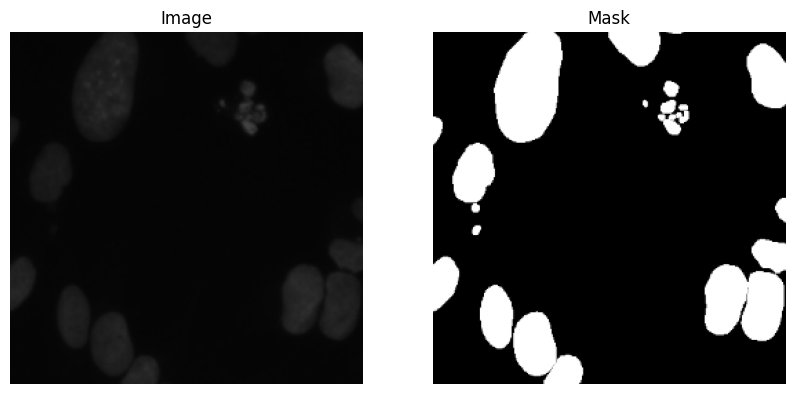

In [12]:
# draw random sample from the dataset

def draw_sample(x, y):
    idx = random.randint(0, len(x)-1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(x[idx])
    ax[0].set_title('Image')
    ax[0].axis('off')
    ax[1].imshow(y[idx].squeeze(), cmap='gray')
    ax[1].set_title('Mask')
    ax[1].axis('off')
    plt.show()

draw_sample(x_train, y_train)

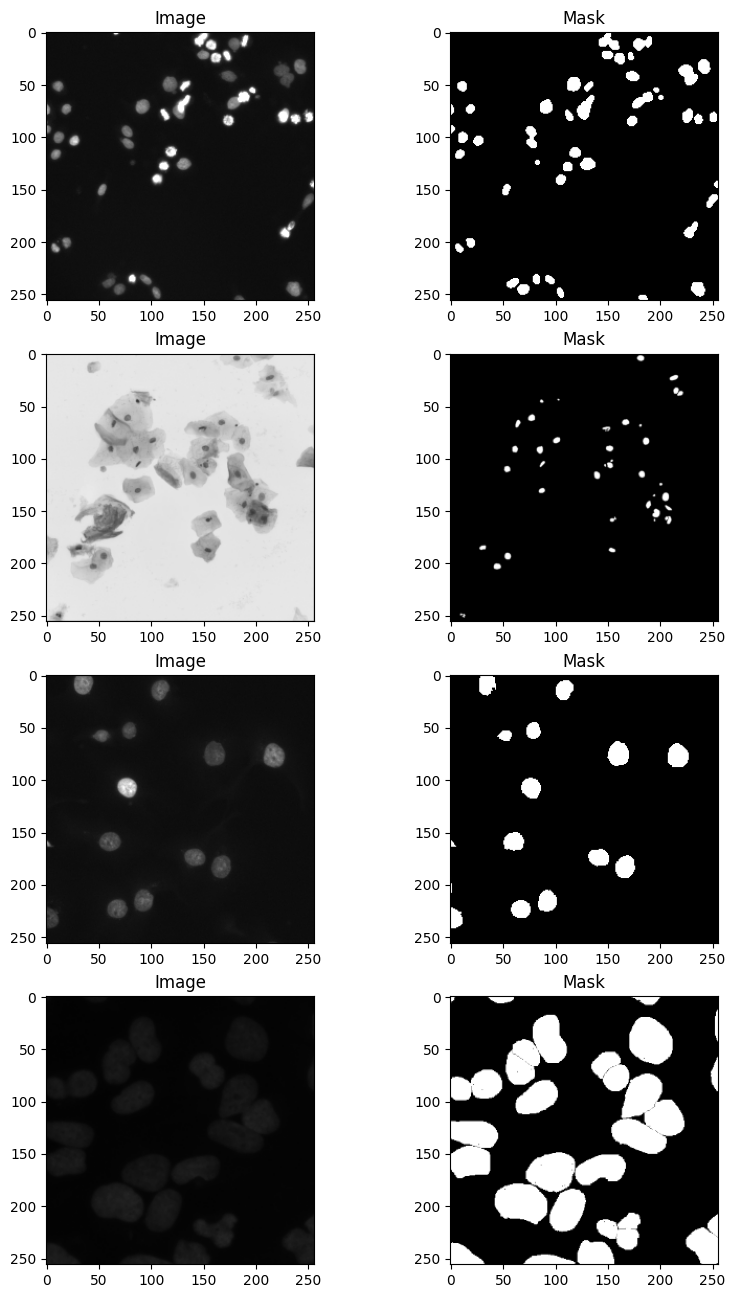

In [13]:

plt.figure(figsize=(20, 16))

x, y = 4, 4
for i in range(y):
    index = random.randint(0, len(x_train))
    plt.subplot(y, x, i * x + 1)
    plt.imshow(x_train[index])
    plt.title('Image')

    plt.subplot(y, x, i * x + 2)
    plt.imshow(y_train[index].squeeze(), cmap='gray')
    plt.title('Mask')

## DATASET

In [14]:
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF


class Nuc_Seg(Dataset):
    def __init__(self, images_np, masks_np):
        self.images_np = images_np
        self.masks_np = masks_np
    
    def __len__(self):
        return len(self.images_np)
    
    def __getitem__(self, idx):
        image_np = self.images_np[idx]
        mask_np = self.masks_np[idx]
        # Convert numpy arrays to tensors
        image = TF.to_tensor(image_np)
        mask = TF.to_tensor(mask_np.astype(np.int32))

        image = TF.resize(image, (256, 256))
        mask = TF.resize(mask, (256, 256))
        
        return image, mask
  

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = SEED)

if STEP_AUGMENTATION > 0:
    X_train_aug, X_val_aug, Y_train_aug, Y_val_aug = train_test_split(x_train_aug, y_train_aug, test_size = 0.1, random_state = SEED)

if STEP_AUGMENTATION > 0:
    X_train = np.concatenate((X_train, X_train_aug), axis = 0)
    Y_train = np.concatenate((Y_train, Y_train_aug), axis = 0)
    X_val = np.concatenate((X_val, X_val_aug), axis = 0)
    Y_val = np.concatenate((Y_val, Y_val_aug), axis = 0)

train_dataset = Nuc_Seg(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataset = Nuc_Seg(X_val, Y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)

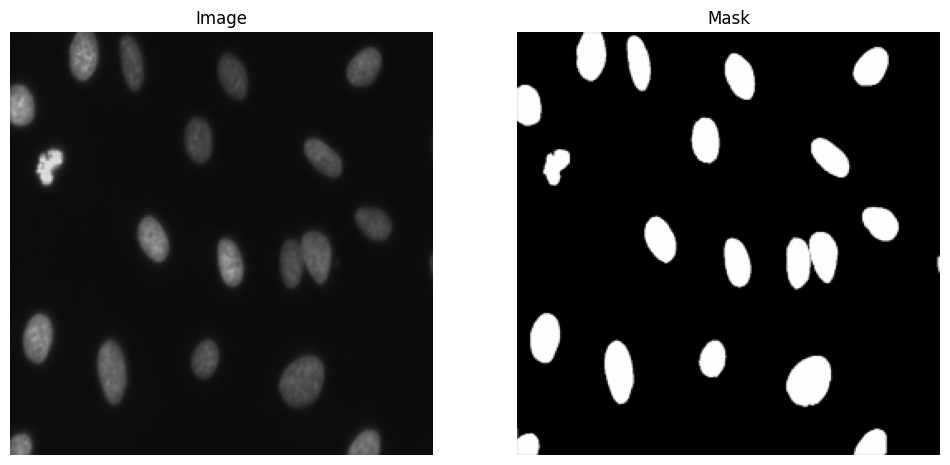

In [16]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def plot_sample(dataset, idx):
    """
    Plots a sample from the dataset.
    
    Args:
        dataset (Dataset): The dataset from which to plot a sample.
        idx (int): The index of the sample to plot.
    """
    image, mask = dataset[idx]

    # Convert tensors to PIL images for plotting
    image = TF.to_pil_image(image)
    mask = TF.to_pil_image(mask)

    # Plot the image and mask
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()

plot_sample(train_dataset, idx=0)



## MODEL

In [17]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [18]:
class UNETV1(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNETV1, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        return self.final_conv(x)

In [19]:
class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNetPlusPlus, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part
        self.down_conv = nn.ModuleList()
        for feature in features:
            self.down_conv.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part
        self.up_conv = nn.ModuleList()
        for feature in reversed(features):
            self.up_conv.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.up_conv.append(DoubleConv(feature * 2, feature))

        self.nested_conv = nn.ModuleList()
        for feature in features:
            self.nested_conv.append(nn.ModuleList([DoubleConv(feature * (i + 2), feature) for i in range(len(features))]))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        nested_connections = []

        # Downward path
        for down in self.down_conv:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Upward path
        for idx in range(len(self.up_conv) // 2):
            skip_connection = skip_connections[idx]

            x = self.up_conv[2 * idx](x)

            nested_concat = torch.cat([x, skip_connection], dim=1)
            nested_conv = self.nested_conv[len(self.up_conv) // 2 - idx - 1][idx]

            if idx > 0:
                for j in range(idx):
                    nested_concat = torch.cat([nested_concat, nested_connections[-(idx - j)]], dim=1)
                nested_conv = self.nested_conv[len(self.up_conv) // 2 - idx - 1][idx - 1]

            x = nested_conv(nested_concat)
            nested_connections.append(x)

            x = self.up_conv[2 * idx + 1](x)

        return self.final_conv(x)

In [20]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(AttentionUNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.attentions = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # Attention blocks
        for feature in reversed(features):
            self.attentions.append(AttentionBlock(feature, feature, feature//2))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            # Apply attention
            skip_connection = self.attentions[idx//2](g=x, x=skip_connection)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [21]:
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


METRICS

## Jaccard Index: Measuring Intersection Over Union (IoU)

The **Jaccard Index** is a metric used to compare the similarity between two sets. It calculates the ratio of the size of the intersection of the sets to the size of their union. Mathematically, it's defined as:

$$
J(A, B) = |A ∩ B| / |A ∪ B|
$$

## Jaccard Loss 

The **Jaccard Loss** is derived from the Jaccard index and serves as a loss function during model training. This loss function is particularly useful for image segmentation tasks where the goal is to optimize the model for accurate segmentation. It's defined as:

$$
\mathcal{L}_{\text{Jaccard}}(\mathbf{p}, \mathbf{t}) = 1 - J(\mathbf{p}, \mathbf{t})
$$

where $J(\mathbf{p}, \mathbf{t})$ is the Jaccard index computed between the predicted and true values.


In [22]:
def jaccard(preds, trues, is_average=True):
    num = preds.size(0)
    
    preds = preds.contiguous()
    trues = trues.contiguous()

    preds = (preds > 0.5).float()
    trues = (trues > 0.5).float()

    intersection = (preds * trues).sum(1)
    scores = (intersection + EPS) / ((preds + trues).sum(1) - intersection + EPS)

    score = scores.sum()
    if is_average:
        score /= num
    return torch.clamp(score, 0., 1.)

def jaccard_round(preds, trues, is_average=True):
    preds = torch.round(preds)
    return jaccard(preds, trues, is_average=is_average)


class JaccardLoss(nn.Module):
    def __init__(self, size_average=True):
        super().__init__()
        self.size_average = size_average

    def forward(self, input, target):
        return jaccard(input, target, self.size_average)
    

## Dice Loss

The Dice Loss is a metric used to evaluate the performance of models in tasks like image segmentation. It focuses on the overlap between the predicted segmentation mask and the ground truth mask, penalizing models that incorrectly classify pixels.

A: Predicted segmentation mask pixels

B: Ground truth segmentation mask pixels

$$
L_Dice(A, B) = 1 - 2 * |A ∩ B| / (|A| + |B|)
$$

In [23]:
def dice_loss(preds, trues, smooth=1e-6, is_average=True):
    preds = preds.contiguous()
    trues = trues.contiguous()

    preds = (preds > 0.5).float()
    trues = (trues > 0.5).float()
    
    intersection = (preds * trues).sum(dim=(1, 2, 3))
    scores = (2. * intersection + smooth) / (preds.sum(dim=(1, 2, 3)) + trues.sum(dim=(1, 2, 3)) + smooth)
    
    if is_average:
        return 1 - scores.mean()
    else:
        return 1 - scores

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()
        self.size_average = size_average
        self.register_buffer('weight', weight)

    def forward(self, input, target):
        if input.max() > 1:
            input = torch.sigmoid(input)
        return dice_loss(input, target, smooth=1e-6, is_average=self.size_average)

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5, smooth=1e-6):
        super(BCEDiceLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_loss = DiceLoss()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, preds, targets):
        # Ensure targets are float
        if targets.max() > 1:
            targets = targets/255
        targets = targets.float()
        targets = (targets > 0.5).float()
        bce = self.bce_loss(preds, targets)
        dice = self.dice_loss(preds, targets)

        return (self.bce_weight * bce) + ((1 - self.bce_weight) * dice)

In [24]:
class BitWiseMetrics(nn.Module):
    def __init__(self, threshold=0.5):
        super().__init__()
        self.threshold = threshold

    def forward(self, input, target):
        return bitwise_metric(input, target, self.threshold)

def bitwise_metric(preds, trues, threshold=0.5):
    preds = (preds > threshold).float()
    return (preds == trues).sum()

In [25]:
def dice_coefficient(preds, targets, smooth=1e-6):
    if preds.max() > 1:
        preds = nn.functional.sigmoid(preds)
    if targets.max() > 1:
        targets = targets / 255.0
    
    preds = preds.contiguous()
    targets = targets.contiguous()

    preds = (preds > 0.5).float()
    targets = (targets > 0.5).float()

    intersection = (preds * targets).sum(dim=(1, 2, 3))
    dice = (2. * intersection + smooth) / (preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3)) + smooth)
    
    return dice.mean().item()

def iou_metric(preds, targets, smooth=1e-6):
    if preds.max() > 1:
        preds = nn.functional.sigmoid(preds)
    if targets.max() > 1:
        targets = targets / 255.0

    preds = preds.contiguous()
    targets = targets.contiguous()
    
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.mean().item()


def accuracy_metric(preds, targets):     
    if preds.max() > 1:
        preds = nn.functional.sigmoid(preds)
        
    if targets.max() > 1:
        targets = targets / 255.0
           
    preds = preds.contiguous()
    targets = targets.contiguous()
    
    preds = (preds > 0.5).float()
    correct = (preds == targets).float()
    
    return correct.sum() / correct.numel()

TRAIN 1

In [26]:
def train_one_epoch(model, train_loader, opt, criterion, metrics, device):
    model.train()
    train_loss = 0.0
    train_scores = {metric_name: 0.0 for metric_name in metrics.keys()}

    for image, mask in train_loader:
        image, mask = image.to(device), mask.to(device)

        opt.zero_grad()
        out = model(image)
        #out = nn.functional.sigmoid(out)
        #if mask.max() > 1:
        #    mask = mask / 255.0
        loss = criterion(out.float(), mask.float())
        #loss.requires_grad = True
        loss.backward()
        opt.step()

        train_loss += loss.item()
        for metric_name, metric_func in metrics.items():
            train_scores[metric_name] += metric_func(out, mask)

    avg_train_loss = train_loss / len(train_loader)
    avg_train_scores = {metric_name: score / len(train_loader)  for metric_name, score in train_scores.items()}

    return avg_train_loss, avg_train_scores

def validate_one_epoch(model, val_loader, criterion, metrics, device):
    model.eval()
    val_loss = 0.0
    val_scores = {metric_name: 0.0 for metric_name in metrics.keys()}

    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)
            out = model(image)

            #out = nn.functional.sigmoid(out)
            #if mask.max() > 1:
            #    mask = mask / 255.0
            loss = criterion(out.float(), mask.float())
            val_loss += loss.item()
            for metric_name, metric_func in metrics.items():
                val_scores[metric_name] += metric_func(out, mask)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_scores = {metric_name: score / len(val_loader)  for metric_name, score in val_scores.items()}

    return avg_val_loss, avg_val_scores

def fit(model, epochs, opt, criterion, train_loader, val_loader, metrics=None, monitor_metric='val_loss', device='cuda', patience=10, min_delta=1e-4):
    if metrics is None:
        metrics = {'iou': iou_metric}

    train_losses = []
    val_losses = []
    train_metrics = {metric_name: [] for metric_name in metrics.keys()}
    val_metrics = {metric_name: [] for metric_name in metrics.keys()}

    best_monitor_value = 0
    best_model_wts = None
    early_stop_counter = 0

    for epoch in range(epochs):
        avg_train_loss, avg_train_scores = train_one_epoch(model, train_loader, opt, criterion, metrics, device)
        avg_val_loss, avg_val_scores = validate_one_epoch(model, val_loader, criterion, metrics, device)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        for metric_name, score in avg_train_scores.items():
            train_metrics[metric_name].append(score)
        
        for metric_name, score in avg_val_scores.items():
            val_metrics[metric_name].append(score)
        
        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}")
        print(f"Train Scores: {avg_train_scores}")
        print(f"Valid Scores: {avg_val_scores}")

        # Early stopping based on the monitored metric
        current_monitor_value = avg_val_scores[monitor_metric]
        
        if current_monitor_value - best_monitor_value > min_delta:
            best_monitor_value = current_monitor_value
            best_model_wts = model.state_dict()
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"{monitor_metric}: {current_monitor_value:.6f} did not improve from {best_monitor_value:.6f} having delta of {current_monitor_value - best_monitor_value:.6f} compared to min_delta of {min_delta:.6f}")
        print(f"Early stopping counter: {early_stop_counter}/{patience}")

        if early_stop_counter >= patience:
            print("Early stopping")
            break

    # Load the best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_metrics': train_metrics,
        'val_metrics': val_metrics,
    }


In [27]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [28]:
model = UNET(in_channels=3, out_channels=1).to(device)
model.apply(weights_init)
criterion = BCEDiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

metrics = {
    'dice': dice_coefficient,
    'iou': iou_metric,
    'accuracy': accuracy_metric
}

history = fit(
    model=model,
    epochs=EPOCHS,
    opt=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    metrics=metrics,
    monitor_metric='dice', 
    device='cuda',
    patience=PATIENCE,
    min_delta=EPS
)

t_losses = history['train_losses']
v_losses = history['val_losses']
t_scores = history['train_metrics']
v_scores = history['val_metrics']

t_dice_scores = t_scores['dice']
v_dice_scores = v_scores['dice']

t_iou_scores = t_scores['iou']
v_iou_scores = v_scores['iou']

t_accuracy_scores = t_scores['accuracy']
v_accuracy_scores = v_scores['accuracy']

print("Training Dice Scores:", t_dice_scores)
print("Validation Dice Scores:", v_dice_scores)
print("Training IOU Scores:", t_iou_scores)
print("Validation IOU Scores:", v_iou_scores)
print("Training Accuracy Scores:", t_accuracy_scores)
print("Validation Accuracy Scores:", v_accuracy_scores)

KeyboardInterrupt: 

In [29]:
name_criterion = "BCEDiceLoss" if isinstance(criterion, BCEDiceLoss) else "DiceLoss" if isinstance(criterion, DiceLoss) else "BCELoss" if isinstance(criterion, nn.BCEWithLogitsLoss) else "JaccardLoss" if isinstance(criterion, JaccardLoss) else "UnknownLoss"

RESULTS_PATH = RESULTS_PATH + name_criterion +'/'

if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)

In [ ]:
# Training Loss
plt.figure()
plt.semilogy(t_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.savefig(f'{RESULTS_PATH}training_loss.png')
plt.close()

# Validation Loss
plt.figure()
plt.semilogy(v_losses, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.savefig(f'{RESULTS_PATH}validation_loss.png')
plt.close()

# Training Score
plt.figure()
plt.semilogy(t_dice_scores, label='Training Score')
plt.title('Training Score')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.savefig(f'{RESULTS_PATH}training_score.png')
plt.close()

# Validation Score
plt.figure()
plt.semilogy(v_dice_scores, label='Validation Score')
plt.title('Validation Score')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.savefig(f'{RESULTS_PATH}validation_score.png')
plt.close()


In [ ]:
def predict(model, image):
    model.eval()
    image = image.to(device)
    out = model(image.float())
    return out

In [30]:
DB_PATH_TEST = os.path.join(DB_PATH, "test/")
DB_PATH_TEST_MASK = os.path.join(DB_PATH, "test_masks/")

# Image properties
img_height = 256
img_width = 256
img_channel = 3

def preprocess(id_list, img_path=DB_PATH_TEST, mask_path=DB_PATH_TEST_MASK, img_height=256, img_width=256, img_channel=3):
    # Initialize lists to store images and masks
    images = []
    masks = []
    
    # Iterate through all the images and masks
    for id_ in tqdm.tqdm(id_list, total=len(id_list)):   
        img_file_path = os.path.join(img_path, id_, 'images', id_ + '.png')
        mask_file_path = os.path.join(mask_path, id_)
        
        
        # Read and resize the image
        img = imread(img_file_path)[:,:,:img_channel]
        img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
        images.append(img)
        
        # Read and resize the mask
        mask = np.zeros((img_height, img_width, 1))
        for mask_file in os.listdir(mask_file_path):
            # read in current mask
            image_path = os.path.join(mask_file_path, mask_file)
            cur_mask = imread(image_path)
            cur_mask = cur_mask[:, :, 1]
            # resize it and adjust the dimension to 128x128x1
            cur_mask = np.expand_dims(resize(cur_mask, (img_height, img_width), mode = 'constant', preserve_range = True), axis = -1)
            mask = np.maximum(mask, cur_mask)
        masks.append(mask)
    
    # Convert lists to numpy arrays
    set_image = np.array(images, dtype=np.uint8)
    set_mask = np.array(masks, dtype=np.uint8)

    return set_image, set_mask

# Get list of image IDs
image_ids = [f for f in os.listdir(DB_PATH_TEST) if os.path.isdir(os.path.join(DB_PATH_TEST, f))]

# Preprocess the images and masks
X_Test, Y_Test = preprocess(image_ids)

# Output the length of the test sets
print(len(X_Test), len(Y_Test))

100%|██████████| 65/65 [00:26<00:00,  2.48it/s]

65 65


(256, 256, 3) (256, 256, 1)


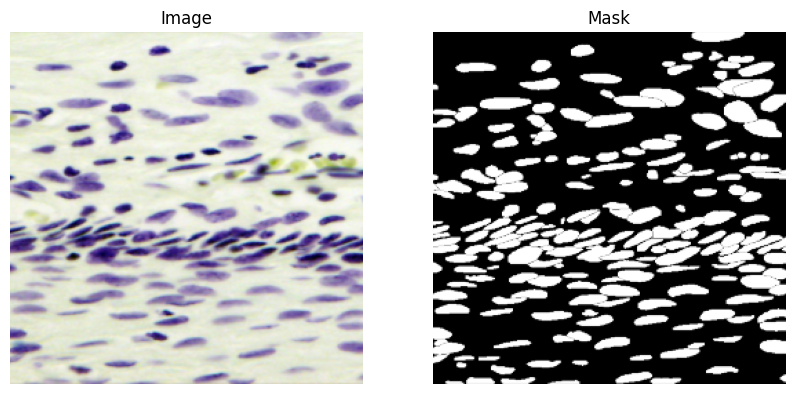

In [33]:

#uid = "958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f"

#index = -1
#for i in val_images:
#    if uid in i:
#        index = val_images.index(i)
#        break

index = random.randint(0, len(X_Test)- 1)
index = 30

print(X_Test[index].shape, Y_Test[index].shape)

test_dataset = Nuc_Seg(X_Test, Y_Test)

image, mask = test_dataset[index]

#print(X_Test[index])

# plot the image and mask
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.show()




In [ ]:
image = image.unsqueeze(0)
mask = mask.unsqueeze(0)

# predict the mask
predicted_mask = predict(model, image)

# plot the image, mask and predicted mask
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(image.squeeze().permute(1, 2, 0))
plt.title("Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Mask")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze().cpu().detach().numpy(), cmap="gray")
plt.title("Predicted Mask")

plt.show()

In [ ]:

# find the maximum and minimum intensity of the predicted mask
max_intensity = predicted_mask.max().item()
min_intensity = predicted_mask.min().item()

print (f"Max Intensity: {max_intensity}, Min Intensity: {min_intensity}")

# plot the predicted mask

stat_image = predicted_mask.squeeze().cpu().detach().numpy()

# normalize stat_image to range [0, 1] using max min formula

stat_image = (stat_image - min_intensity) / (max_intensity - min_intensity)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(stat_image, cmap="gray")
plt.title("Predicted Mask")

plt.subplot(1, 2, 2)
plt.hist(stat_image.flatten() , bins=50)
plt.title("Histogram of Mask")
plt.show()


In [ ]:
#normalize the predicted mask using max and min
def normalize_mask(mask):
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    return mask

def threshold_mask(mask, threshold):
    mask = mask > threshold
    return mask

def plot_threshold_mask(mask, threshold, title="Threshold Mask"):
    mask = threshold_mask(mask, threshold)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Threshold: {threshold}, {title}")
    plt.axis("off")
    plt.show()

def add_accumulate_threshold_mask(mask, threshold):
    mask = threshold_mask(mask, threshold)
    return mask


step_thresholds = np.linspace(0.2, 0.9, 10)
step_thresholds = step_thresholds[::-1]

output = normalize_mask(predicted_mask)

prediction = output.squeeze().cpu().detach().numpy()
accumulation_mask = torch.zeros_like(mask)

# Create a horizontal subplot
fig, axs = plt.subplots(1, len(step_thresholds), figsize=(20, 5))

# Loop through thresholds and plot each mask
for i, threshold in enumerate(step_thresholds):
    accumulation_mask = add_accumulate_threshold_mask(prediction, threshold)
    axs[i].imshow(accumulation_mask, cmap='gray')
    axs[i].set_title(f'Threshold: {threshold:.2f}')
    axs[i].axis('off')  # Hide the axes for better visualization

plt.tight_layout()
plt.show()


In [ ]:
def evaluation_dice_coefficient(preds, targets, smooth=1e-6):
    if ( preds.max() > 1 ):
        preds = preds / 255.0
    if ( targets.max() > 1 ):
        targets = targets / 255.0
    intersection = np.sum(preds * targets)
    dice = (2. * intersection + smooth) / (np.sum(preds) + np.sum(targets) + smooth)
    return dice.mean()


In [ ]:
metrics = evaluation_dice_coefficient

step_thresholds_graph = np.linspace(0.01, 0.99, 50)
step_thresholds_graph = step_thresholds_graph[::-1]

ground_truth_mask = mask.squeeze().cpu().detach().numpy()
# Calculate the dice coefficient for each threshold relative to the ground truth mask
dice_scores = [metrics(threshold_mask(prediction, threshold), ground_truth_mask) for threshold in step_thresholds_graph]

# Plot the dice scores
plt.figure()
plt.plot(step_thresholds_graph, dice_scores, marker='o')
plt.title('Dice Coefficient vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Dice Coefficient')
plt.grid()
plt.show()

print("Best Threshold:", step_thresholds_graph[np.argmax(dice_scores)])


In [ ]:
CHECKPOINT_PATH = "attentionunet_chckpnt_{name_criterion}.pth.tar"

def save_checkpoint(state, filename="unet_chckpnt.pth.tar"):
    torch.save({
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}, RESULTS_PATH + filename)


In [ ]:
save_checkpoint(model, CHECKPOINT_PATH)

In [ ]:
from torch.optim import Optimizer
from torch.nn import Module

def load_ckp(checkpoint_fpath: str, model: Module, optimizer: Optimizer):
    # Load checkpoint
    checkpoint = torch.load(checkpoint_fpath)
    
    # Check if 'state_dict' and 'optimizer' keys are in checkpoint dictionary
    if 'state_dict' not in checkpoint or 'optimizer' not in checkpoint:
        raise KeyError("Checkpoint is missing required keys 'state_dict' and 'optimizer'")
    
    # Load model state
    model.load_state_dict(checkpoint['state_dict'])
    
    # Load optimizer state
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    return model, optimizer, checkpoint

a = UNET(in_channels=3, out_channels=1).to(device)
opt = torch.optim.Adam(a.parameters(), lr=LEARNING_RATE)

# Example call
a_model, opt, chk = load_ckp(RESULTS_PATH + CHECKPOINT_PATH, a, opt)


In [ ]:
def invert_colors(image):
    return 1 - image


def enhance_brightness(image, factor=1.2):

    bright_mask = image > 0.5

    enhanced_image = image.clone()
    enhanced_image[bright_mask] = torch.clamp(image[bright_mask] * factor, 0, 1)
    return enhanced_image

In [ ]:
import cv2

def predict(model, image):
    model.eval()
    image = image.to(device)
    out = model(image.float())
    #out = (out - out.min()) / (out.max() - out.min())
    out = nn.functional.sigmoid(out)
    return out

TEST_PATH = RESULTS_PATH  + "test/"

if not os.path.exists(TEST_PATH):
    os.makedirs(TEST_PATH)

# save predicted masks only in a folder called prediction, with the name of the image

PREDICT_PATH = TEST_PATH + "prediction/"

if not os.path.exists(PREDICT_PATH):
    os.makedirs(PREDICT_PATH)


for index in range(0, len(X_Test)):
    image = X_Test[index]
    image = TF.to_tensor(image)
    image = image.unsqueeze(0)
    predicted_mask = predict(model, image)

    cv2.imwrite(f'{PREDICT_PATH}{index}.png', predicted_mask.squeeze().cpu().detach().numpy())

    plt.figure(figsize=(20, 3))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze().permute(1, 2, 0).cpu().detach().numpy())
    plt.title("Image")
    plt.axis("off")

    # Plot the predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask.squeeze().cpu().detach().numpy(), cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")


    # Save the figure
    plt.savefig(f'{TEST_PATH}{index}_test_comparison.png')
    plt.close()

In [ ]:
DB_PATH_TEST = os.path.join(DB_PATH, "test2/")

set_image = np.zeros((len(DB_PATH_TEST), 256, 256, 3), dtype = np.uint8)

img_height = 256
img_width = 256
img_channel = 3

def preprocess(ids, path=DB_PATH_TEST, img_height=256, img_width=256, img_channel=3):
    # Initialize an empty array to store the images
    set_image = np.zeros((len(ids), img_height, img_width, img_channel), dtype=np.uint8)
    
    # Initialize an index for valid images
    valid_image_index = 0
    
    for n, id_ in tqdm.tqdm(enumerate(ids), total=len(ids)):
        try:
            cur_path = os.path.join(path, id_)
            img = imread(os.path.join(cur_path, 'images', id_ + '.png'))[:, :, :img_channel]
            img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
            set_image[valid_image_index] = img
            valid_image_index += 1
        except Exception as e:
            print(f"Error processing image {id_}: {e}")
            continue

    # Truncate the array to only include the valid images
    set_image = set_image[:valid_image_index]
    
    return set_image

X_Test = preprocess(os.listdir(DB_PATH_TEST))
print(len(X_Test))

In [ ]:
def predict(model, image):
    model.eval()
    image = image.to(device)
    out = model(image.float())
    #out = (out - out.min()) / (out.max() - out.min())
    out = nn.functional.sigmoid(out)
    return out

TEST_PATH = RESULTS_PATH  + "test2/"

if not os.path.exists(TEST_PATH):
    os.makedirs(TEST_PATH)

PREDICT_PATH = TEST_PATH + "prediction2/"

if not os.path.exists(PREDICT_PATH):
    os.makedirs(PREDICT_PATH)


for index in range(0, len(X_Test)):
    image = X_Test[index]
    image = TF.to_tensor(image)
    image = image.unsqueeze(0)
    predicted_mask = predict(model, image)
    
    cv2.imwrite(f'{PREDICT_PATH}{index}.png', predicted_mask.squeeze().cpu().detach().numpy())

    plt.figure(figsize=(20, 3))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze().permute(1, 2, 0).cpu().detach().numpy())
    plt.title("Image")
    plt.axis("off")

    # Plot the predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask.squeeze().cpu().detach().numpy(), cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")


    # Save the figure
    plt.savefig(f'{TEST_PATH}{index}_test_comparison.png')
    plt.close()